In [1]:
%env CUDA_VISIBLE_DEVICES=0
from utils import *
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import numpy as np
from region_traverser import *

model_name = "OS-Copilot/OS-Atlas-Base-7B"
model = Qwen2VLForConditionalGeneration.from_pretrained(model_name, torch_dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_name)

ds = load_screenspot_ds()

env: CUDA_VISIBLE_DEVICES=0


2024-11-15 00:18:33.564267: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 00:18:33.589923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 00:18:34.063907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
def get_coordinate_prediction(image, target):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"In this UI screenshot, what is the position of the element corresponding to the command \"{target}\" (with bbox)?"},
                #{"type": "text", "text": f"In the attached UI screenshot, what is the bbox of the element corresponding to the command \"{target}\"? Write your final answer in the following format (x1, y1, x2, y2)"},
            ]
        }
    ]
    
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    text += f"<|object_ref_start|>{target}<|object_ref_end|><|box_start|>("
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=False, clean_up_tokenization_spaces=False
    )
    #print(output_text)
    coords_str = output_text[0].split("<|box_end|>")[0]
    #print(coords_str)
    coords = coords_str.replace('(', '').replace(')', '').replace('[', '').replace(']', '').split(',')
    x1, y1, x2, y2 = map(int, coords)
    bbox = [x1, y1, x2, y2]
    
    midpoint_x = (x1 + x2) / 2
    midpoint_y = (y1 + y2) / 2
    
    result = (midpoint_x, midpoint_y)
    return result

star the chatgpt project
(753.0, 369.5)


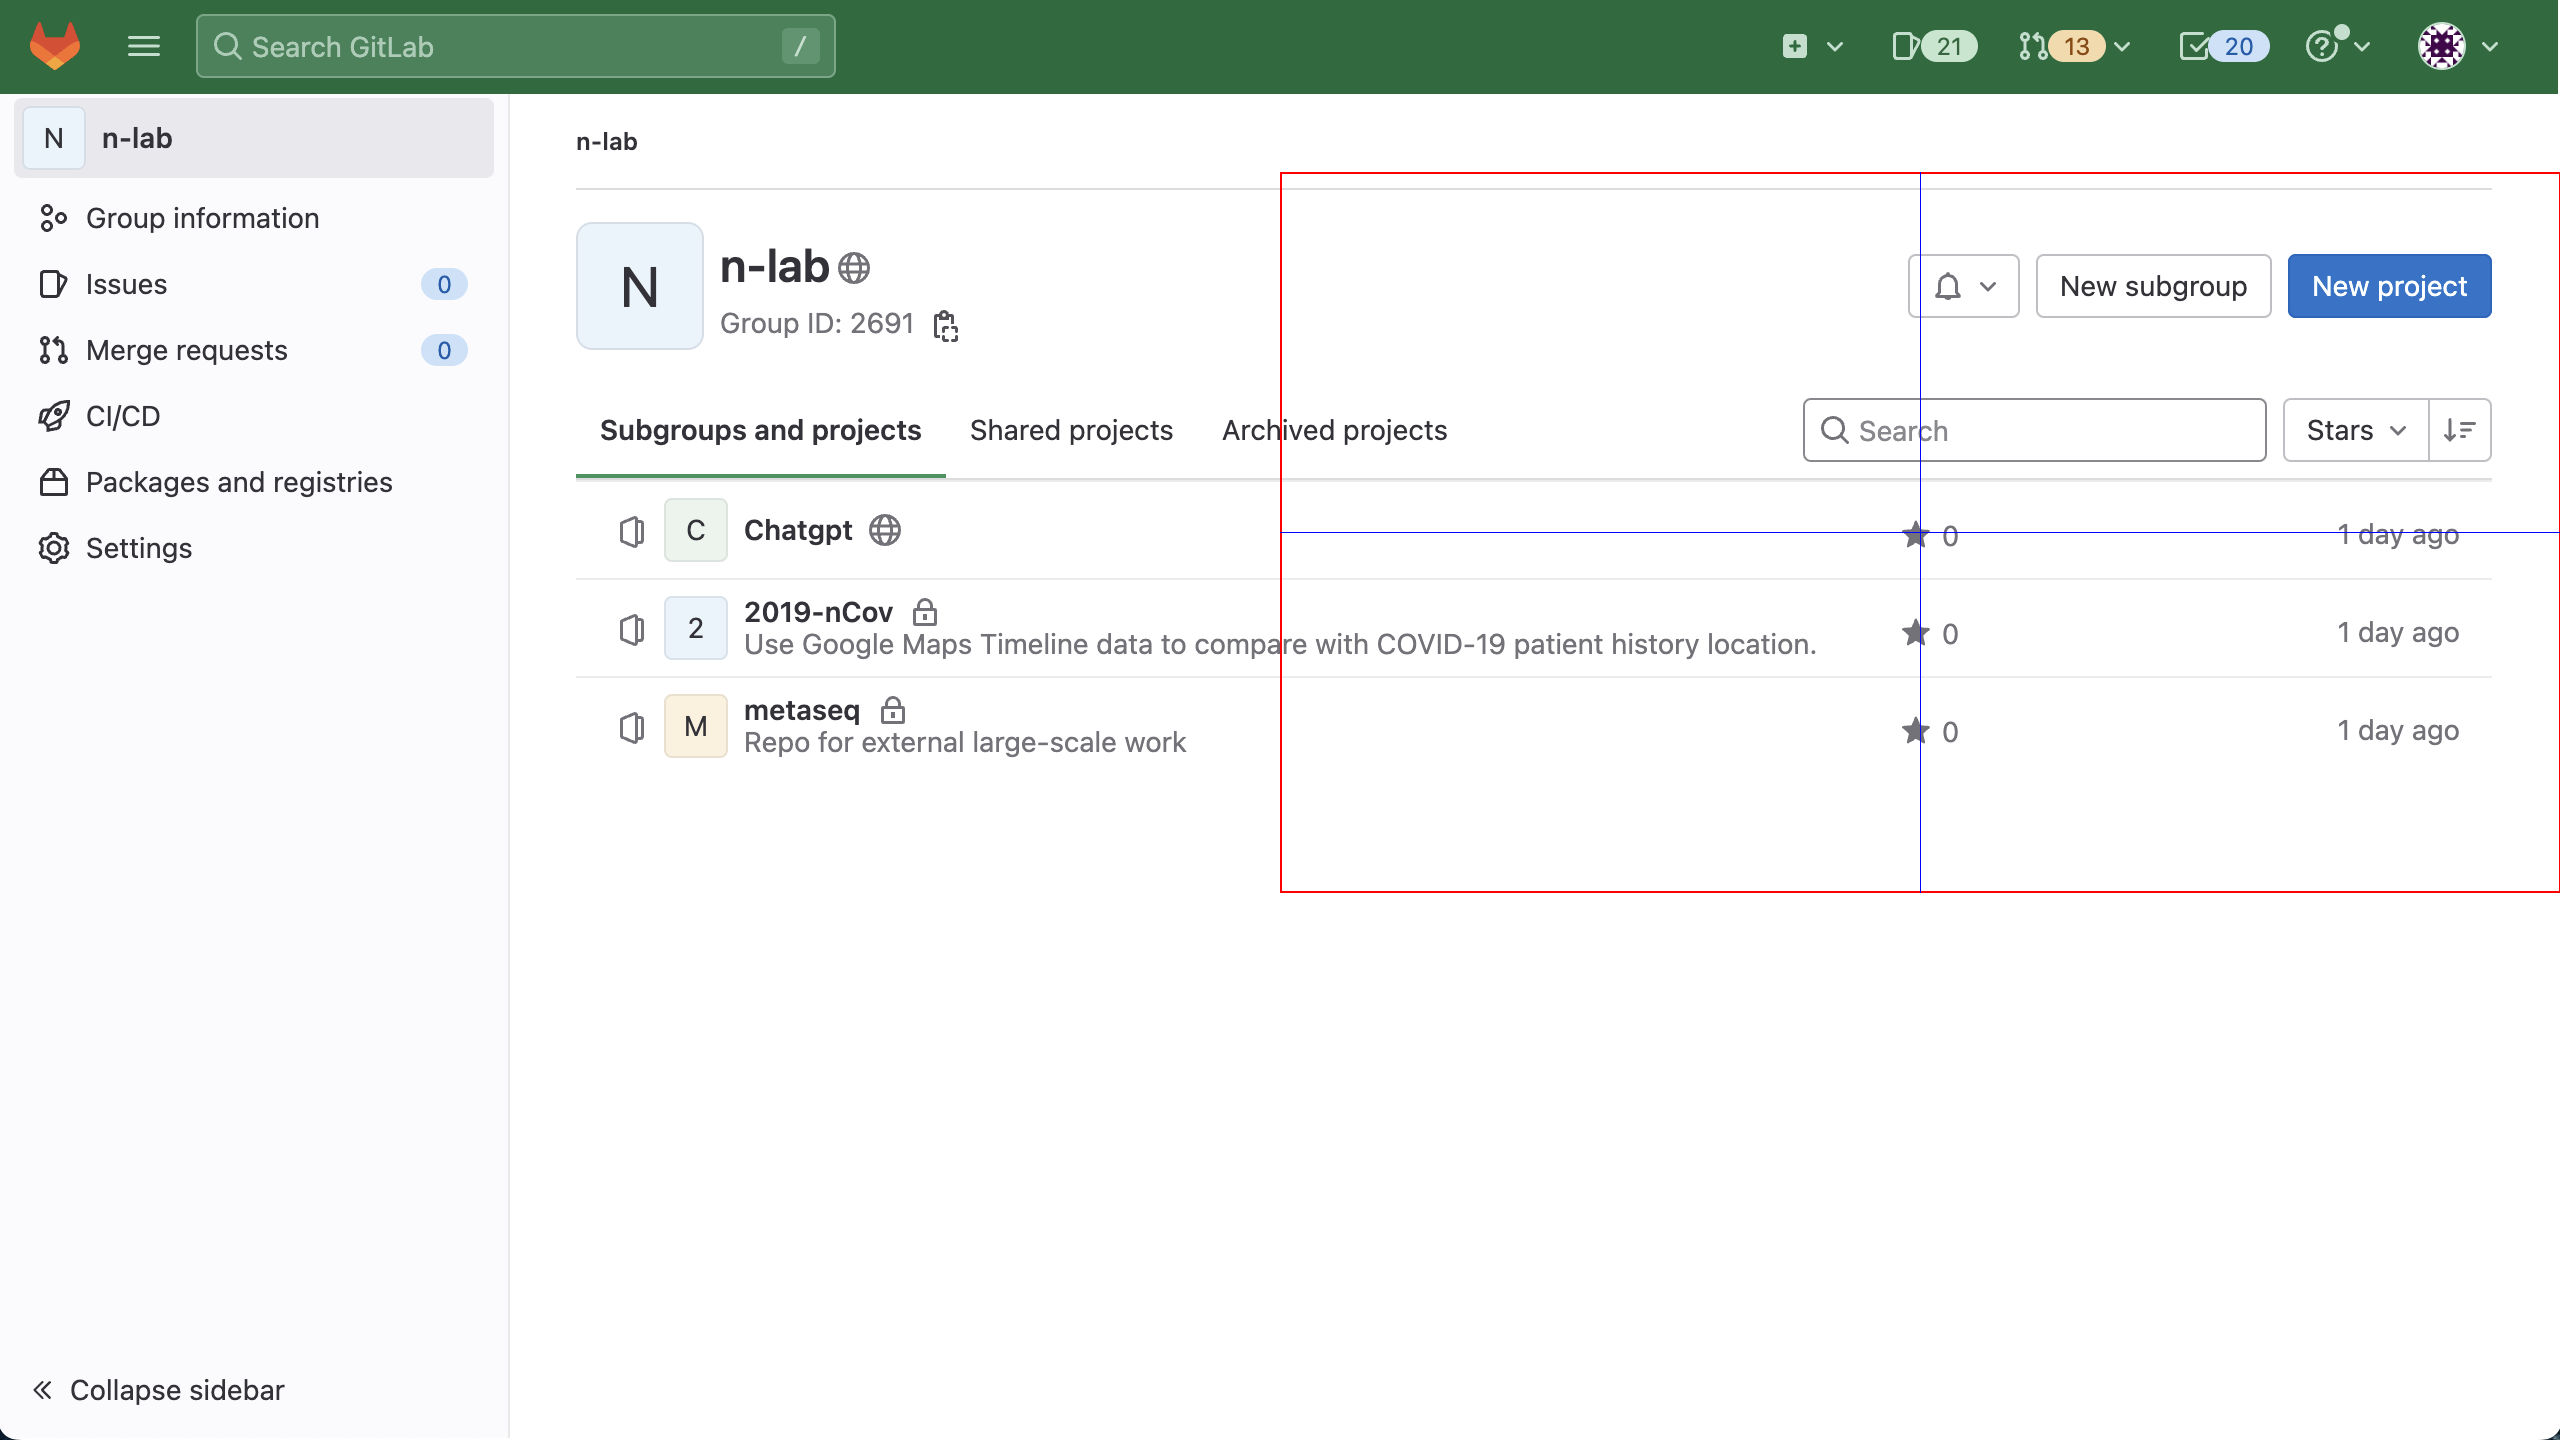

(500.0, 514.0)


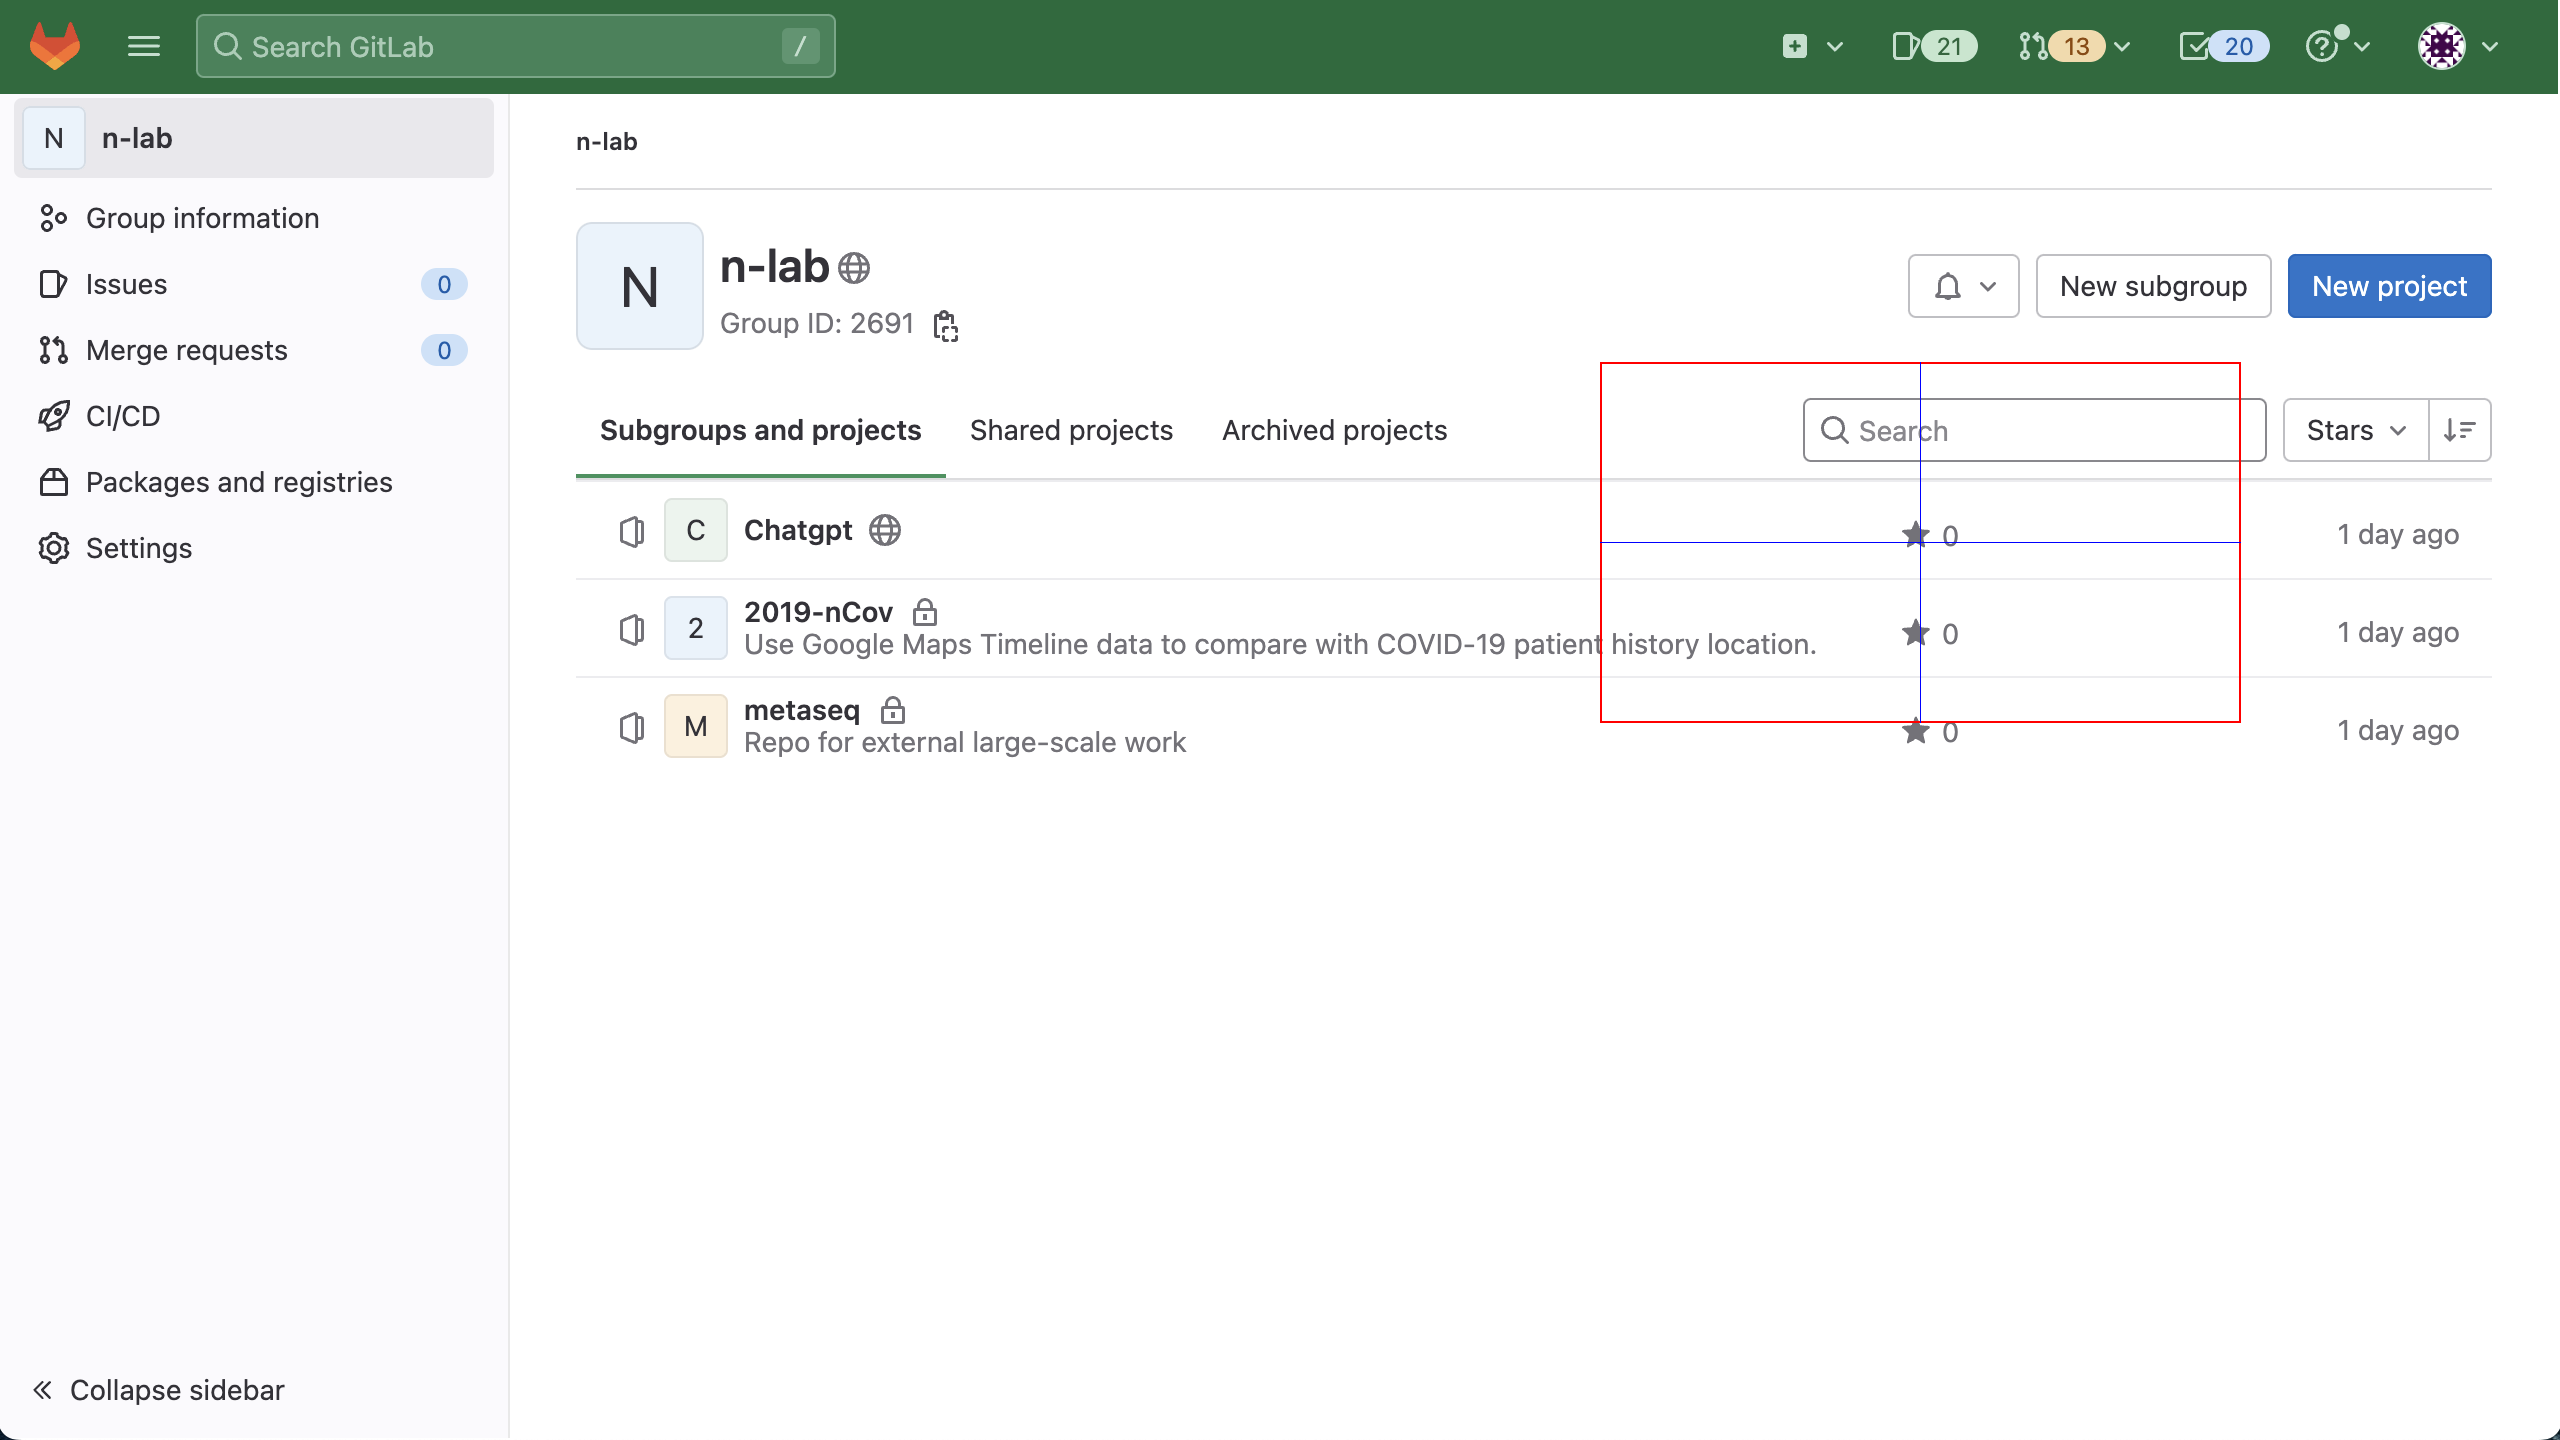

(498.5, 752.5)


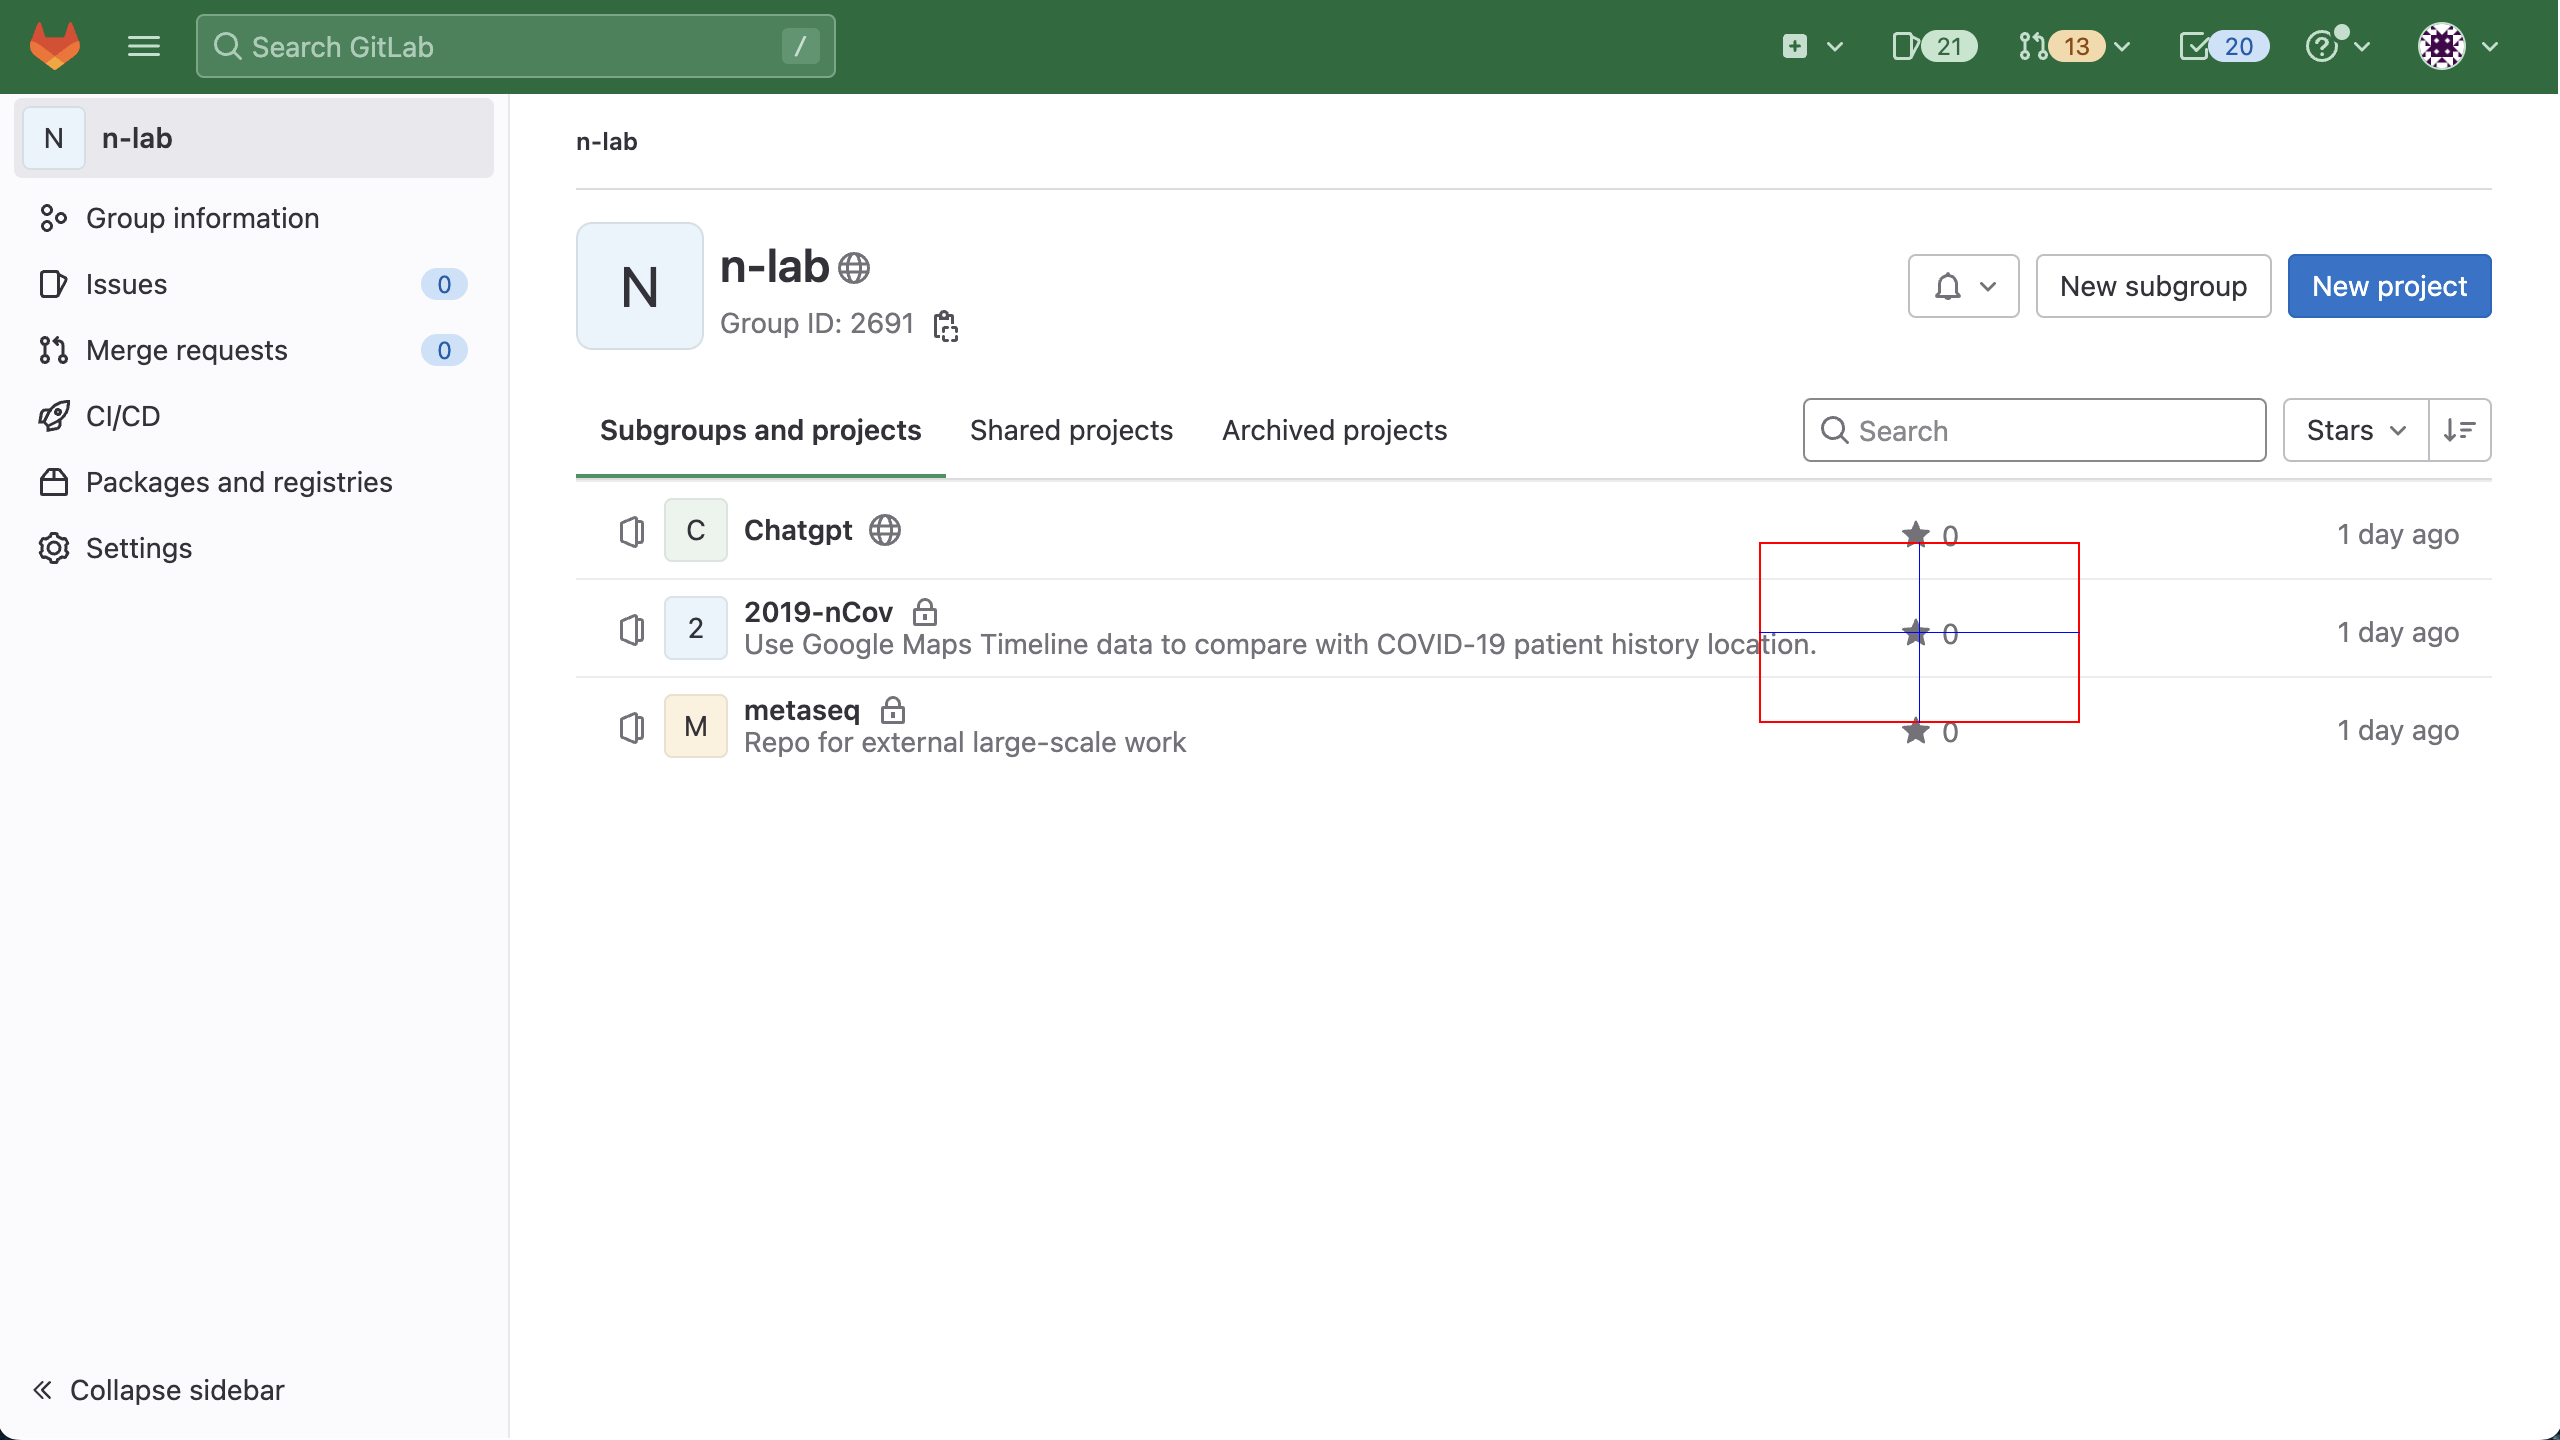

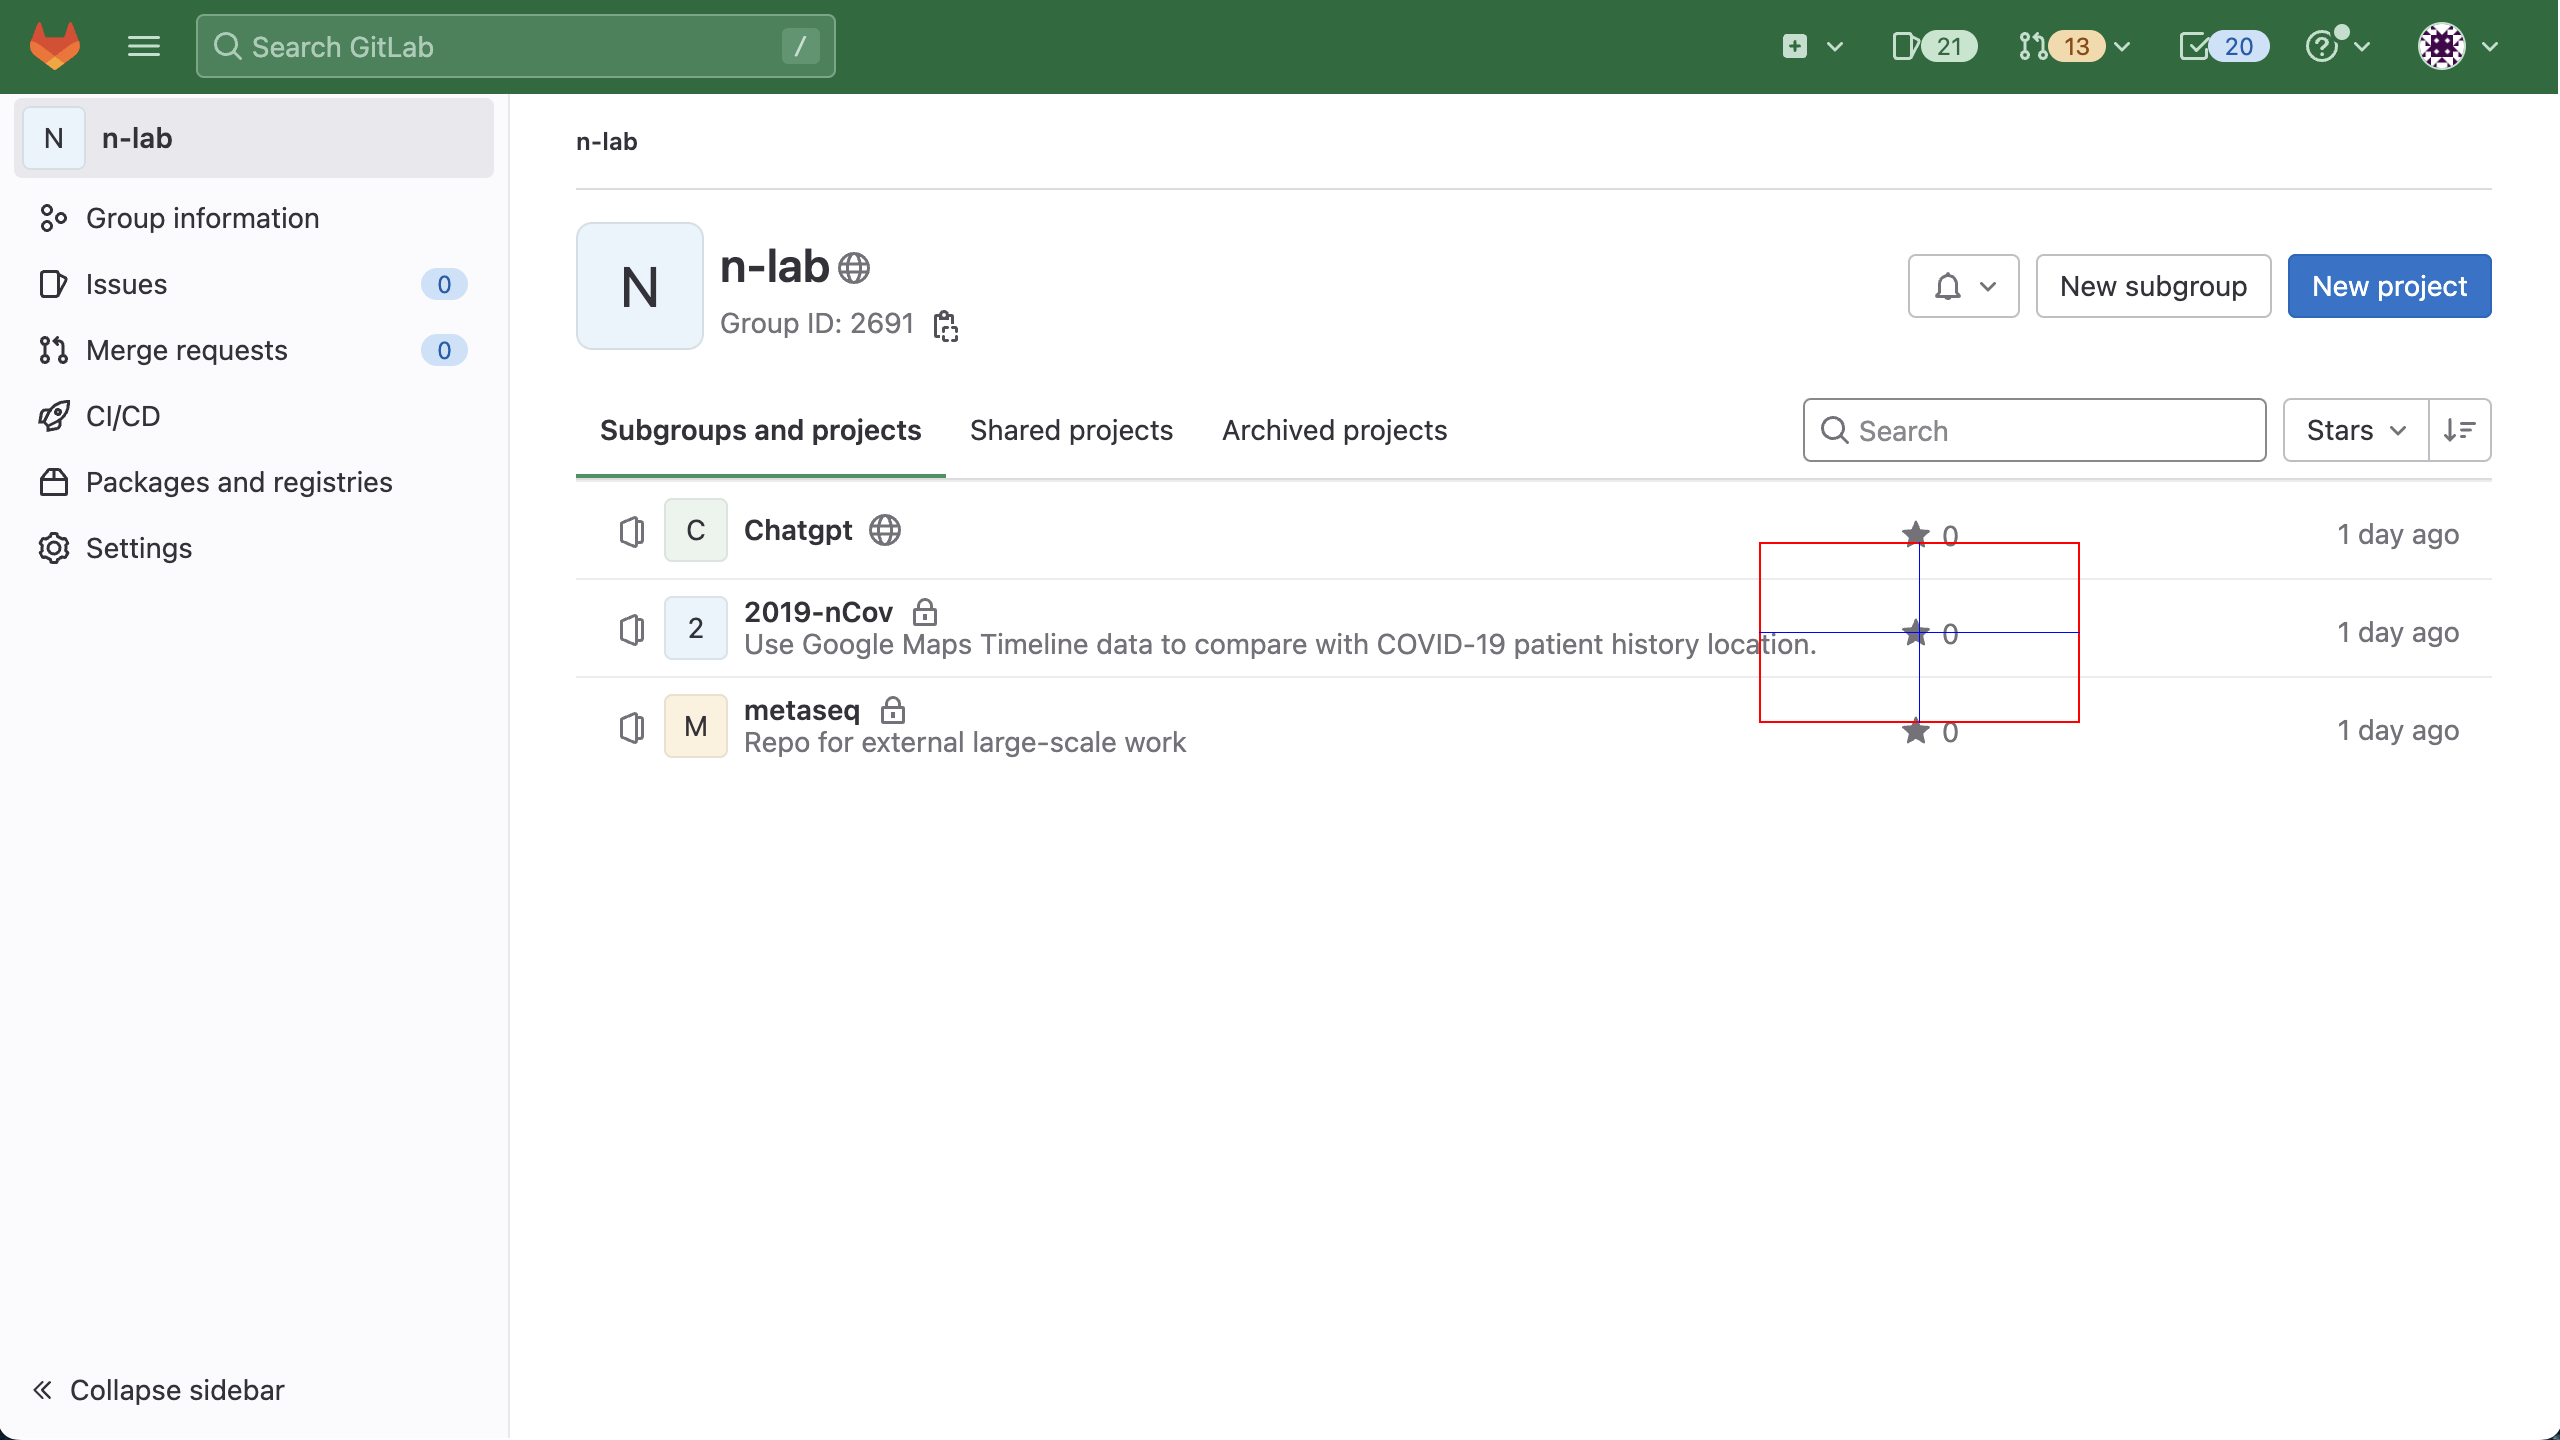

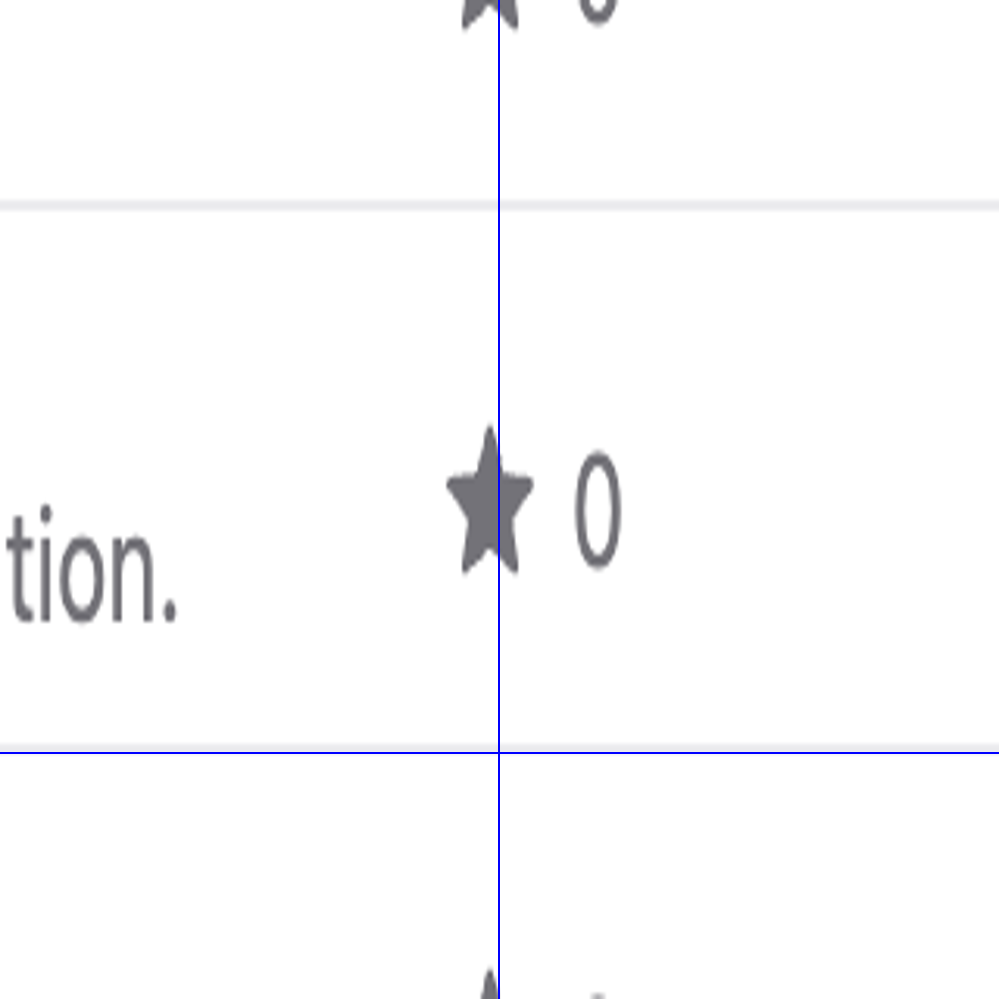

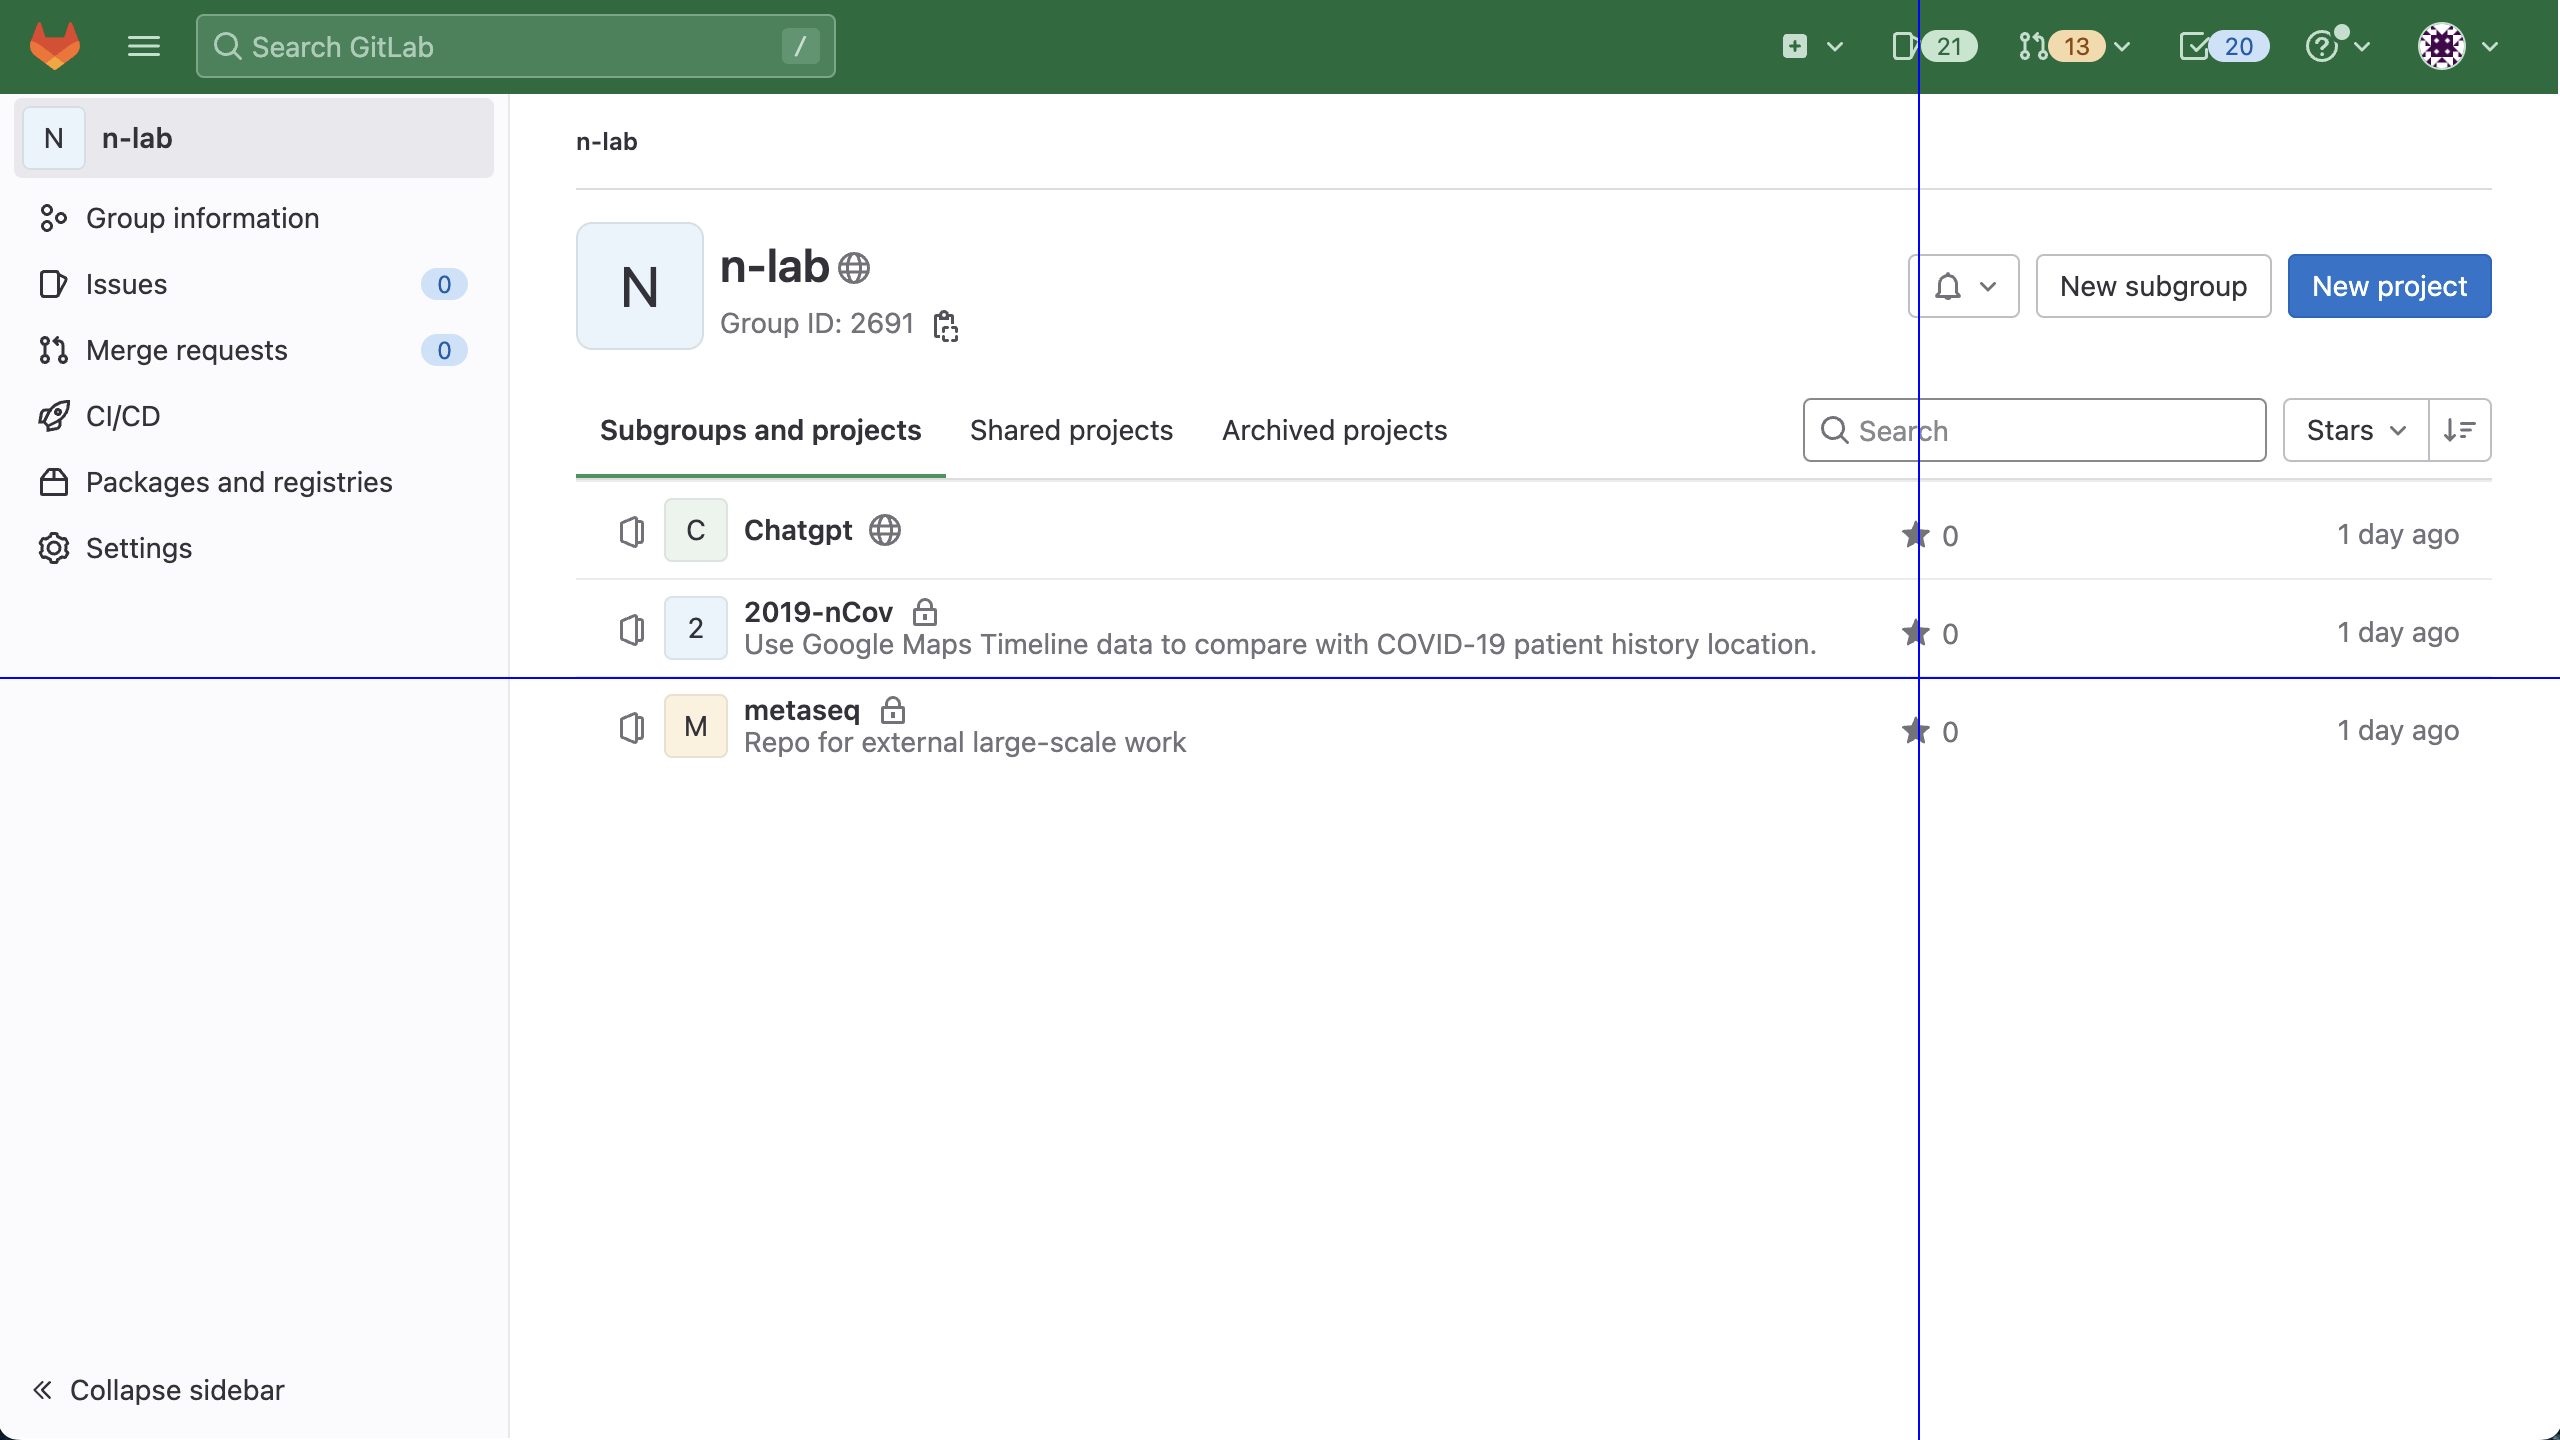

False

In [22]:
dim = 999

def eval_row_baseline(row, verbose=False):
    target = row['target']
    og_size = row['image'].size
    current_region = row['image'].resize((dim,dim))
    x, y = get_coordinate_prediction(current_region, target)
    x = x * current_region.size[0]
    x = y * current_region.size[1]
    porp_x = x / dim
    porp_y = y / dim

    x = og_size[0] * porp_x
    y = og_size[1] * porp_y

    if verbose:
        print(target)
        print(current_region.size)
        print(x,y)
        render_crosshair(row['image'], x, y).convert("RGB").show()
    return is_in_bbox(row['bbox'], x, y)

def eval_row(row, verbose=False):
    target = row['target']
    current_region = row['image'].copy()

    traverser = RegionTraverser(current_region)
    if verbose: print(target)
    k = 3
    #render_crosshair_center(current_region).show()
    for i in range(k):
        image_prompt = current_region.resize((dim, dim))
        prediction_coord = get_coordinate_prediction(image_prompt, target)
        pred_x, pred_y = prediction_coord
        
        if verbose: print(prediction_coord)
        if i != k-1:
            traverser.consume_coordinate(pred_x, pred_y)
            result_image = traverser.get_highlighted_image()
            current_region = traverser.get_cropped_image().resize((dim,dim))

        if verbose: result_image.convert("RGB").show()
    final_bbox = traverser.get_bounding_box()

    last_porp_x = pred_x / dim
    last_porp_y = pred_y / dim
    
    delta_x = (final_bbox[2] - final_bbox[0]) * last_porp_x
    delta_y = (final_bbox[3] - final_bbox[1]) * last_porp_y

    x,y = final_bbox[0] + delta_x, final_bbox[1] + delta_y
    if verbose:
        render_crosshair(current_region, pred_x, pred_y).convert("RGB").show()
        render_crosshair(row['image'], x, y).convert("RGB").show()
        #draw_bbox_on_image(row['image'], pred_bbox).convert("RGB").show()
    return is_in_bbox(row['bbox'], x, y)

eval_row(ds["web"]["icon"][35], True)

In [15]:
from tqdm import tqdm
devices = ["web", "mobile", "desktop"]
ui_types = ["text", "icon"]

weights = {}
eval_result = {}

for d in devices:
    for t in ui_types:
        test_set = ds[d][t]
        weights[f"{d} - {t}"] = len(test_set)
        results = []
        for row in tqdm(test_set):
            res = eval_row(row)
            results.append(res)
        eval_result[f"{d} - {t}"] = len([x for x in results if x]) / len(test_set)

100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [09:25<00:00,  4.04s/it]


In [16]:
eval_result

{'web - text': 0.8695652173913043,
 'web - icon': 0.7233009708737864,
 'mobile - text': 0.9304029304029304,
 'mobile - icon': 0.74235807860262,
 'desktop - text': 0.9226804123711341,
 'desktop - icon': 0.7714285714285715}

In [17]:
import numpy as np
np.average(list(eval_result.values()), weights=list(weights.values()))

0.8333333333333334